In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#### Below, we will set the default plot aesthetics to make them look nicer

In [3]:
sns.set_style("white")

#### After loading the data again, we will take the subset of the data in order to make the plots clearer.  We accomplish this with the 'key' of cntry.  Notice how we make use of the .unique() function.

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv")
print(df.head())
print(df.cntry.unique())

  cntry  idno  year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  \
0    CH   5.0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   
1    CH  25.0     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   
2    CH  26.0     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   
3    CH  28.0     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   
4    CH  29.0     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   

   gndr  agea  partner  
0   2.0  60.0      1.0  
1   2.0  59.0      1.0  
2   1.0  24.0      2.0  
3   2.0  64.0      1.0  
4   2.0  55.0      1.0  
['CH' 'CZ' 'DE' 'ES' 'NO' 'SE']


### Categorical Variables
#### Since most models will only run on numerical data, in order to get the information fro a categoriacal variable with X levels, we need to create X-1 numerical features.  Each would be coded as as either 1 or 0.  
#### The 'cntry' variable has 6 levels - we only need 5 features to represent all the information.  If we know that all but 'SE' are 0, then 'SE' must be 1.  
#### The level without a feature is called the reference value
#### Taking this information, lets make an indicator that gathers all the countries that we think are related:

In [5]:
features = pd.get_dummies(df['cntry'])
features['Nordic'] = np.where((df['cntry'].isin(['NO', 'SE'])), 1, 0)

print(pd.crosstab(features['Nordic'], df['cntry']))

cntry     CH    CZ  DE    ES    NO    SE
Nordic                                  
0       1546  1316  28  2426     0     0
1          0     0   0     0  1462  1816


### Changing Variables
#### A continuous variable can be transformed into a categorical variable.  
#### Example:  If we wanted to compare older adults (age > 65 to all other ages in the sample, we could make an 'OlderAdult' indicator feature by doing the following:

In [6]:
features['Adult_65plus'] = np.where(df['agea']>=65, 1, 0)

In [7]:
print(df['agea'].groupby(features['Adult_65plus']).describe())

               count       mean        std   min   25%   50%   75%    max
Adult_65plus                                                             
0             6682.0  40.874738  13.958596  15.0  29.0  42.0  53.0   64.0
1             1673.0  73.815302   6.650086  65.0  69.0  72.0  78.0  114.0


### Combining two or more highly-correlated variables
#### 2 highly-correlated variable can be averaged to create a feature, or one can be droppped.  
#### 3 or more highly-correlated variables can also be combined using a statistical method called Principal Component Analysis (PCA).
#### PCA reduces the correlated set of variables into a smaller set of uncorrelated fatures.

In [8]:
corrmat = df.corr()

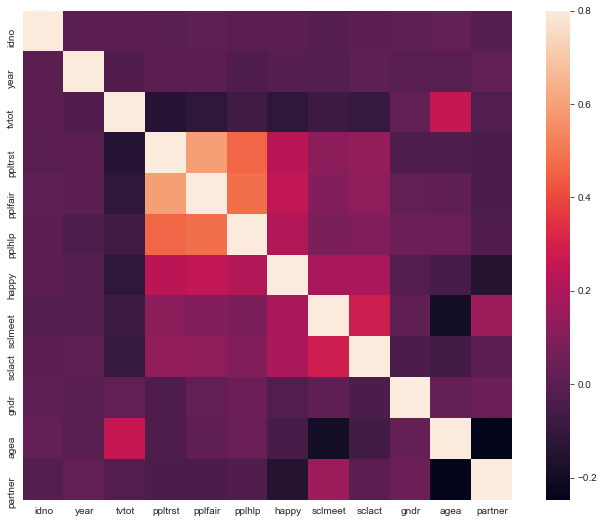

                  ppltrst   pplfair    pplhlp  trust_fair_help
ppltrst          1.000000  0.592001  0.462562         0.834209
pplfair          0.592001  1.000000  0.480918         0.841674
pplhlp           0.462562  0.480918  1.000000         0.789318
trust_fair_help  0.834209  0.841674  0.789318         1.000000


In [9]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

#Making averages below are 'pplfair, 'ppltrst' and pplhlip' are pretty redundant with each other.
#Since the numbers are in different scales (1 ranges between 0 to 100 while another ranges from 0 to 7), 
#we need to scale them before averaging them.  
#We do this by:  subtracting the average of each variable from all values in that variable, then dividing by the
#standard deviation.
means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
features['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

plotdf = df.loc[:, ['ppltrst', 'pplfair', 'pplhlp']]
plotdf['trust_fair_help'] = features['trust_fair_help'] 
corrmat2 = plotdf.corr()

print(corrmat2)

### Dealing with non-normality
#### Normality is often model-assumption.  Non-normal variables can sometimes be transformed into normally-distributed features using transformations.  You can do this in different ways such as taking the square root, the inverse, or the log of the variable.

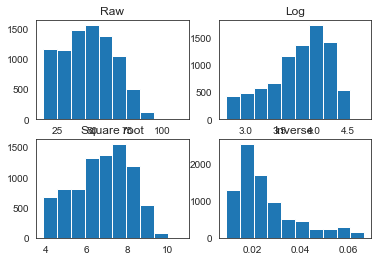

In [10]:
#We will start by making a four-panel plt
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['agea'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['agea'].dropna()))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['agea'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/df['agea'].dropna())
plt.title('Inverse')
plt.show()

In [11]:
#We will make a feature from the log panel
features['log_age'] = np.log(df['agea'])

### Creating linear relationships
#### Since many models assume that the relationship between a feature and an outcome is linear, there is work we need to do if a variable has a non-linear component to its relationship with the outcome.  In order to capture non-linearity while keeping the model happy, you will need to create quadratic or higher-level features by doing the following:
- square the variable
- cube the variable
- multiply the variable by itself

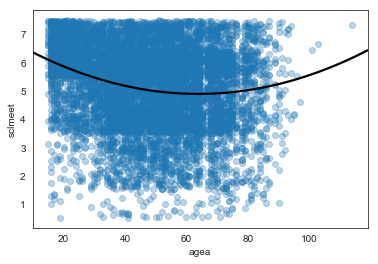

In [12]:
sns.regplot(
    df['agea'],
    y=df['sclmeet'],
    y_jitter=.49,
    order=2,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.show()

features['age_squared'] = df['agea'] * df['agea']

### Making variables easier to understand in light of the research question
#### You want your variables to align with what you are trying to show.  If your research question involves a certain unit of measure, but your variable is measured a different way, you can create a feature to show this.  You can also re-encode a variable into a feature that matches the researh question.
#### If our research question is about predicting time spent watching tv, and we think sad people watch more., then recoding the "happy" variable will make the correlation between 'tvtot' and 'happy' a little simpler to parse.

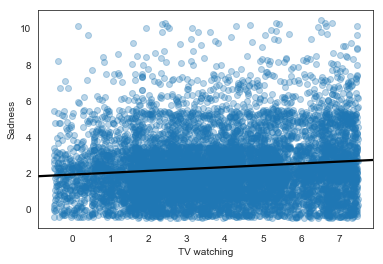

In [13]:
# Reverse-coding the 'happy' variable so that higher scores mean less
# happiness (and thus possibly more sadness).

features['Sadness'] = max(df['happy']) - df['happy']

sns.regplot(
    df['tvtot'],
    features['Sadness'],
    x_jitter=.49,
    y_jitter=.49,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.xlabel('TV watching')
plt.ylabel('Sadness')
plt.show()

### Leveling the playing field
#### We can normalize all the variables to share the same scale because features that vary in range can result in incorrect estimates.

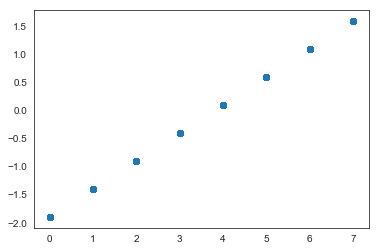

               idno          year         tvtot       ppltrst       pplfair  \
count  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03   
mean  -6.977221e-18 -5.302688e-16 -5.930638e-17 -8.372665e-17  1.814077e-16   
std    1.000061e+00  1.000061e+00  1.000061e+00  1.000061e+00  1.000061e+00   
min   -6.364414e-02 -1.000614e+00 -1.900914e+00 -2.516209e+00 -2.832624e+00   
25%   -6.196385e-02 -1.000614e+00 -9.053021e-01 -7.108364e-01 -4.741304e-01   
50%   -6.087847e-02  9.993865e-01  9.031023e-02  1.918499e-01 -2.431735e-03   
75%   -5.925039e-02  9.993865e-01  5.881164e-01  6.431931e-01  9.409657e-01   
max    1.734276e+01  9.993865e-01  1.583729e+00  1.997223e+00  1.884363e+00   

             pplhlp         happy       sclmeet        sclact          gndr  \
count  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03  8.147000e+03   
mean  -9.768109e-17  2.372255e-16 -1.116355e-16 -2.581572e-16  1.186128e-16   
std    1.000061e+00  1.000061e+00  1.000061e+00  1.

In [14]:
from sklearn import preprocessing

# Select only numeric variables to scale.
df_num = df.select_dtypes(include=[np.number]).dropna()

# Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)

# The new features contain all the information of the old ones, but on a new scale.
plt.scatter(df_num['tvtot'], df_scaled['tvtot'])
plt.show()

# Lookit all those matching means and standard deviations!
print(df_scaled.describe())

### All about interactions
#### If you suspect that the relationship between the outcome and a feature depends on the value of a second feature, you may want to create a feature that represents the interaction.
#### Example:  Maybe watching tv makes people sad when they do it alone.  Perhaps people that live with a partner do not watch as much tv.  We can multiply our 'partner' indicator by the 'sadness' feature' to create this interaction.  This would represent that concept that we introduced about our hypothesis.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


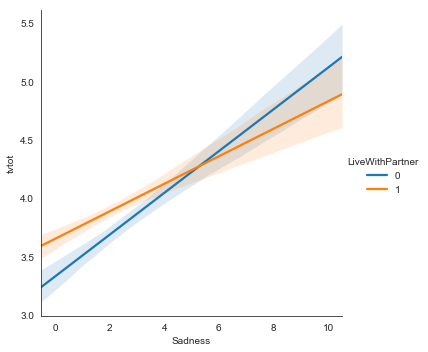

In [15]:
# Create a better indicator for 'partner.' Currently it is coded 1 for
# living with a partner and 2 for not living with a partner.
features['LiveWithPartner'] = np.where(df['partner'] == 1, 1, 0)

# Create the interaction.
features['Sad_Partner'] = features['Sadness'] * features['LiveWithPartner']

# A plot of an interaction.
# Add the 'tvtot' feature to the features data frame for plotting.
features['tvtot'] = df['tvtot']
sns.lmplot(
    x='Sadness',
    y='tvtot',
    hue='LiveWithPartner',
    data=features,
    scatter=False
)
plt.show()

#### Our graph above seems to reflect that people who don't live with a partner watch more TV when they are sad - or they get sadder when watching TV.  Because of this, this interaction could be a good feature to include.

## TDLAS Drill
### Now that we have gone through the entire exercise, I will be categorizing each of the variables in the ESS dataset as categorical or continuous.  If it's continous, is it ordinal, interval, or ration variables?

### 1.  Variables in ESS dataset
- cntry
- idno
- year
- tvtot
- ppltrst
- pplfair
- pplhlp
- happy
- sclmeet
- scl
- gender
- agea
- partner

### What is the difference between a categorical and continuous variable?
#### Categorical variables contain a finite number of categories or distinct groups (gender, country, etc).
#### Contiunous variables are numeric variables that have an infinit number of values between any two values (can be numeric or date/time)

### Ordinal, Interval, and Ratio variables
#### Ordinal - indicate rank order.  They are often treated like categorical features in analyses, because it doesn't make sense to use them in most mathematical operations.
#### Interval - indicated both rank-order and distance.  Temperature is a good example.  Interval variables can be treated as either categorical or continuous features, depending on how comfortable you are with the assumption made by most models that a continuous variable naturally has an absolute zero point.
#### Ratio - indicate rank, distance, and a meaningful absolute zero value. When a ration has a score of 0, we know that none of the quantity measured by the variable is present.  A good example is age.

- act/cntry:  categorical
- idno:  continous and ordinal
- year:  continous and interval
- tvtot:  continous and ratio
- ppltrst:  categorical
- pplfair:  categorical
- pplhlp:  categorical
- happy:  continuous and ordinal
- sclmeet:  continuous and ordinal
- scl:  continuous and ordinal
- gender:  categorical
- agea:  continuous and ratio
- partner:  categorical
